In [1]:
#Import libraries
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical, np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
#Use hyperas for CNN hyperparameters optimisation
!pip install hyperas

In [0]:
from hyperas import optim
from hyperopt import Trials, STATUS_OK, tpe
from hyperas.distributions import choice, uniform

In [2]:
#Mount to google drive for easy access to files for import/export
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#Import globalVars to keep track of count for each hyperas iteration
import sys
sys.path.append('/content/gdrive/My Drive')
import globalVars

In [0]:
def data():
  xTrainEmotionExtraData = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTrainEmotionExtraData.npy')
  yTrainEmotionExtraData = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTrainEmotionExtraData.npy')
  xTestEmotion = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTestEmotion.npy')
  yTestEmotion = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTestEmotion.npy')
  return xTrainEmotionExtraData, yTrainEmotionExtraData, xTestEmotion, yTestEmotion

In [0]:
#Tune hyperparameters for filters, kernel size, number of FC layers, number of neurons in each FC layer, dropout, learning rate, batch size
#Set class weights based on test set
#Set Early Stopping criteria based on validation loss

def createModel(xTrainEmotionExtraData, yTrainEmotionExtraData, xTestEmotion, yTestEmotion):
    cnnModelEmotion = Sequential()
    cnnModelEmotion.add(Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(150,150,1)))
    cnnModelEmotion.add(BatchNormalization())
    cnnModelEmotion.add(MaxPooling2D(pool_size=(2,2)))
    cnnModelEmotion.add(Conv2D(filters={{choice([8,16,32])}}, kernel_size={{choice([3,5])}}, activation='relu'))
    cnnModelEmotion.add(BatchNormalization())
    cnnModelEmotion.add(MaxPooling2D(pool_size=(2,2)))
    cnnModelEmotion.add(Conv2D(filters={{choice([8,16,32])}}, kernel_size={{choice([5,7])}}, activation='relu'))
    cnnModelEmotion.add(BatchNormalization())
    cnnModelEmotion.add(MaxPooling2D(pool_size=(2,2)))
    cnnModelEmotion.add(Flatten())

    cnnModelEmotion.add(Dense({{choice([512,256,128])}}, activation='relu'))
    cnnModelEmotion.add(Dropout({{choice([0.2,0.5])}}))
    cnnModelEmotion.add(Dense({{choice([256,128,64])}}, activation='relu'))
    cnnModelEmotion.add(Dropout({{choice([0.2,0.5])}}))
    cnnModelEmotion.add(Dense({{choice([128,64,32])}}, activation='relu'))
    cnnModelEmotion.add(Dropout({{choice([0.2,0.5])}}))

    if {{choice(['three', 'four'])}} == 'four':
      cnnModelEmotion.add(Dense({{choice([64,32,16])}}, activation='relu'))
      cnnModelEmotion.add(Dropout({{choice([0.2,0.5])}}))

    cnnModelEmotion.add(Dense(4, activation='softmax'))
    
    Ad = optimizers.Adam(lr={{choice([0.01,0.001])}}, beta_1=0.9, beta_2=0.999, amsgrad=False)
    cnnModelEmotion.compile(loss='categorical_crossentropy', optimizer=Ad, metrics=['accuracy'])

    y_integers = np.argmax(yTestEmotion, axis=1)
    classWeights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    classWeightsEmotion = dict(enumerate(classWeights))

    globalVars.globalVar += 1
    checkpointPath = '/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/Hyperas/BatchNormalisation/TestClassWeights/hyperasEmotion' + str(globalVars.globalVar) + '.h5'

    keras_callbacks   = [
          EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001),
          ModelCheckpoint(checkpointPath, monitor='val_loss', save_best_only=True, mode='min')
    ]

    result = cnnModelEmotion.fit(xTrainEmotionExtraData, yTrainEmotionExtraData, 
                                 validation_data=(xTestEmotion, yTestEmotion), 
                                 epochs=100, 
                                 batch_size={{choice([8,16])}},
                                 class_weight=classWeightsEmotion,
                                 callbacks=keras_callbacks, 
                                 verbose=0)
    
    valLoss = np.amin(result.history['val_loss'])
    print('Best validation loss of epoch:', valLoss)

    return {'loss':valLoss, 'status':STATUS_OK, 'model':cnnModelEmotion}

In [0]:
#https://github.com/maxpumperla/hyperas
#Select best model with hyperparameters that give lowest validation loss
bestRun, bestModel = optim.minimize(model=createModel, 
                                    data=data, 
                                    algo=tpe.suggest, 
                                    max_evals=50, 
                                    trials=Trials(),
                                    notebook_name='gdrive/My Drive/Google_Collab/HyperasEmotion_BatchNormalisation_testCW')

xTrainEmotionExtraData, yTrainEmotionExtraData, xTestEmotion, yTestEmotion = data()
print("Evalutation of best performing model:")
test = bestModel.evaluate(xTestEmotion, yTestEmotion)
print('Test loss:', test[0])
print('Test accuracy:', test[1])
print("Best performing model chosen hyper-parameters:")
print(bestRun)    

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from keras.models import Sequential, load_model
except:
    pass

try:
    from keras.layers import Dense, Dropout, Activation, Flatten
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
except:
    pass

try:
    from keras.utils import to_categorical, np_utils
except:
    pass

try:
    from keras.callbacks import EarlyStopping, ModelCheckpoint
except:
    pass

try:
    from keras.wrappers.scikit_learn import KerasClassifier
except:
    pass

try:
    from keras import optimizers
except:
    pass

try:
    from sklearn.utils.class_weight import compute_class_weight
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import warnings
except:
    pass

try:
    from hyperas import optim
except:
    pass



In [4]:
xTrainEmotionExtraData = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTrainEmotionExtraData.npy')
yTrainEmotionExtraData = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTrainEmotionExtraData.npy')
xTestEmotionExtraData = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTestEmotion.npy')
yTestEmotionExtraData = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTestEmotion.npy')
testEmotion = load_model('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/Hyperas/BatchNormalisation/TestClassWeights/Best_0.760_0.728.h5')
train = testEmotion.evaluate(xTrainEmotionExtraData, yTrainEmotionExtraData, verbose=0)
print('Train loss:', train[0])
print('Train accuracy:', train[1])
test = testEmotion.evaluate(xTestEmotionExtraData, yTestEmotionExtraData, verbose=0)
print('Test loss:', test[0])
print('Test accuracy:', test[1])

Train loss: 0.3020991001279304
Train accuracy: 0.9178197064989518
Test loss: 0.7600245685672443
Test accuracy: 0.7275747506325427


In [6]:
testEmotion.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 148, 148, 8)       80        
_________________________________________________________________
batch_normalization_61 (Batc (None, 148, 148, 8)       32        
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 72, 72, 8)         584       
_________________________________________________________________
batch_normalization_62 (Batc (None, 72, 72, 8)         32        
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 30, 30, 16)      

In [0]:
#Model predictions
predictions = testEmotion.predict_classes(xTestEmotionExtraData, verbose=0)
print(predictions)

[1 2 1 ... 1 0 1]


In [0]:
yTestEmotionExtraData = pd.DataFrame(yTestEmotionExtraData).idxmax(axis=1)

In [0]:
predProbs = testEmotion.predict(xTestEmotionExtraData, verbose=0)
print(predProbs)

[[1.7030948e-01 4.0218055e-01 1.9432025e-01 2.3318966e-01]
 [1.2731861e-03 2.6586619e-01 7.1354425e-01 1.9316373e-02]
 [2.5993881e-01 4.7578174e-01 1.1954845e-01 1.4473100e-01]
 ...
 [4.8223332e-02 5.2823347e-01 3.8549191e-01 3.8051315e-02]
 [8.9827073e-01 1.0164890e-01 1.5341622e-05 6.5112130e-05]
 [1.4432138e-01 3.9014289e-01 1.3766159e-01 3.2787415e-01]]


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(yTestEmotionExtraData, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(yTestEmotionExtraData, predictions, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(yTestEmotionExtraData, predictions, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(yTestEmotionExtraData, predictions, average='macro')
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(yTestEmotionExtraData, predProbs, multi_class='ovo', average='macro')
print('ROC AUC: %f' % auc)
# confusion matrix
cm = confusion_matrix(yTestEmotionExtraData, predictions)
print(cm)

Accuracy: 0.727575
Precision: 0.693086
Recall: 0.622737
F1 score: 0.648288
ROC AUC: 0.870841
[[374  98   1   6]
 [ 58 393  22  20]
 [  4  64  75   6]
 [  4  43   2  34]]


In [0]:
from sklearn.metrics import classification_report
emotions = ['happy','normal','sad/angry/disgusted','surprised/fearful']
metrics = classification_report(yTestEmotionExtraData,predictions,target_names=emotions)
print(metrics)

                     precision    recall  f1-score   support

              happy       0.85      0.78      0.81       479
             normal       0.66      0.80      0.72       493
sad/angry/disgusted       0.75      0.50      0.60       149
  surprised/fearful       0.52      0.41      0.46        83

           accuracy                           0.73      1204
          macro avg       0.69      0.62      0.65      1204
       weighted avg       0.74      0.73      0.72      1204



The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_true.

In [0]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
#Add Normalization Option
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label') 

Normalized confusion matrix


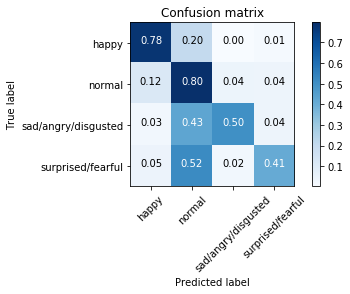

In [0]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(yTestEmotionExtraData, predictions)
plot_confusion_matrix(cm,emotions,normalize=True)

In [0]:
actual = list(yTestEmotionExtraData)
print(actual)

[1, 0, 3, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 3, 1, 0, 2, 0, 3, 1, 0, 1, 2, 0, 0, 0, 1, 1, 0, 3, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 3, 1, 3, 0, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 3, 3, 1, 3, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 1, 2, 3, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 3, 1, 0, 1, 1, 3, 1, 0, 3, 3, 0, 1, 0, 1, 1, 1, 0, 3, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 3, 0, 1, 1, 1, 1, 0, 0, 2, 0, 2, 1, 3, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 3, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 1, 3, 0, 0, 3, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 3, 0, 1, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 3, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 

In [0]:
#Check for wrongly classified images and group them based on emotion
no = []
hp = []
sd = []
sr = []

for i in range(len(actual)):
  if actual[i]!=predictions[i]:
    if actual[i]==0:
      hp.append(i)
    elif actual[i]==1:
      no.append(i)
    elif actual[i]==2:
      sd.append(i)
    elif actual[i]==3:
      sr.append(i)
    else:
      print('Error')

In [0]:
print(len(no))
print(len(hp))
print(len(sd))
print(len(sr))

100
105
74
49


In [0]:
indicesTest = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/indicesTest.npy')
imagesCombined = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/imagesCombined.npy')
targetDf = pd.read_csv('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/targetDf.csv')

In [0]:
emotionsDict = {0:'hp',
                1:'no',
                2:'sd',
                3:'sr'}

In [0]:
def checkWronglyClassifiedEmotionsResults(emotionType, index):
  if emotionType == 'no':
      cv2_imshow(imagesCombined[indicesTest[no[index]]])
      print(targetDf.loc[indicesTest[no[index]],:])
      print('Predicted Emotion:',emotionsDict[predictions[no[index]]])
      print(predProbs[no[index]])
  if emotionType == 'hp':
      cv2_imshow(imagesCombined[indicesTest[hp[index]]])
      print(targetDf.loc[indicesTest[hp[index]],:])
      print('Predicted Emotion:',emotionsDict[predictions[hp[index]]])
      print(predProbs[hp[index]])
  if emotionType == 'sd':
      cv2_imshow(imagesCombined[indicesTest[sd[index]]])
      print(targetDf.loc[indicesTest[sd[index]],:])
      print('Predicted Emotion:',emotionsDict[predictions[sd[index]]])
      print(predProbs[sd[index]])
  if emotionType == 'sr':
      cv2_imshow(imagesCombined[indicesTest[sr[index]]])
      print(targetDf.loc[indicesTest[sr[index]],:])
      print('Predicted Emotion:',emotionsDict[predictions[sr[index]]])
      print(predProbs[sr[index]])

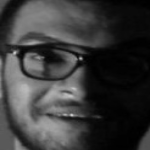

Unnamed: 0                                             3164
filename      MahA_00945_m_28_i_nf_nc_hp_2016_2_e0_nl_o.jpg
name                                                   MahA
gender                                                    m
age                                                      28
emotion                                                  hp
emotionCat                                                0
Name: 3164, dtype: object
Predicted Emotion: no
[0.2591272  0.5118865  0.1533936  0.07559276]


In [0]:
checkWronglyClassifiedEmotionsResults('hp',30)